Demo of LSTM + embedding + multiple features with Keras

In [1]:
%matplotlib inline

## Parameters to be set by user

Larger noise power means that the LSTM job is tougher

- For noise_input = 0, noise_output = 0, `test loss = mse = 9e-5`
- For noise_input = 3, noise_output = 0.1, `test loss = mse = 0.0016`
- For an untrained LSTM predicting a flat line = 0.5, `test loss = mse = 0.0279`

Note that `test loss` is computed in the last cell in this notebook

In [2]:
# Noise power to add to input
# Set to [0,32]
# noise_input = 0
noise_input = 3
# noise_input = 32

# Noise power to add to target
# Set to [0,1]
# noise_output = 0
noise_output = 0.1
# noise_output = 10

## Start of code

In [3]:
from keras.layers import Input, Embedding, concatenate
from keras.models import Sequential
import numpy as np
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Flatten
from keras.models import Model

Using TensorFlow backend.


In [4]:
# Data
# Input is 3D matrix: 1st dimension is time, 2nd is the sequences, 3rd is the features
#          This would be built from a 2D matrix with dimensions time x features, adding the sequences dimension
# Output is just a 1 dimensional vector
vocab_size=32
look_back = 5
n_features = 3
n_time = 1000

input_array = np.random.randint(vocab_size, size=(n_time, look_back, n_features))

# Case 1: simple. Just choose one of the features
# target = input_array[:,-1,0].squeeze() / vocab_size

# Case 2: average of features
target = input_array[:,-1,:].sum(axis=1) / vocab_size / n_features

# add noise on top of input *after* having computed the target
if noise_input > 0:
    input_array = input_array + np.random.randint(noise_input, size = input_array.shape)
    input_array = np.minimum(input_array, vocab_size-1)

# add noise on top of target
if noise_output > 0:
    target = target + noise_output*np.random.rand(*target.shape)
    target = np.minimum(target, 1)
    target = np.maximum(target, 0)

# summary of shapes
len(input_array), [x.shape for x in input_array][:3], target.shape

(1000, [(5, 3), (5, 3), (5, 3)], (1000,))

In [5]:
# modify input_array to become list of 2D matrices for each feature
input_array = [input_array[:,:,i].squeeze() for i in range(n_features)]

input_train = [x[:(n_time*2//3),:] for x in input_array]
target_train = target[:(n_time*2//3)]

input_test = [x[(n_time*2//3):,:] for x in input_array]
target_test = target[(n_time*2//3):]

In [6]:
# Model

# input is an array of inputs, where we're using the multi-input feature of Keras
# From https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
inputs = [Input(shape=(look_back,)) for x in range(n_features)]

# Choose the desired dimensionality of the embedding
desired_dimension = 2

# proceed with embedding each feature matrix
x = [Embedding(input_dim=vocab_size, output_dim=desired_dimension, input_length=look_back)(y) for y in inputs]

# concatenate all embedding outputs
x = concatenate(x)

# regular keras-fu from here on
x = LSTM(5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=[output]) # <<< set multi-input to single-output here
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 2)         64          input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [7]:
history = model.fit(
  input_train,
  y=target_train,
  epochs=125, verbose=0, validation_split=0.2, shuffle=True
)

## Prediction

In [8]:
predicted = model.predict(input_test)

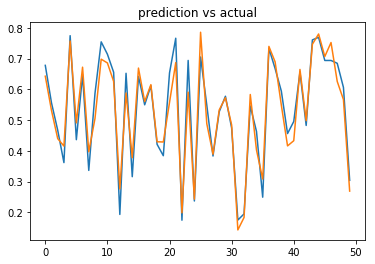

In [9]:
from matplotlib import pyplot as plt

n_show = 50

plt.plot(predicted[:n_show])
plt.plot(target_test[:n_show])
plt.title("prediction vs actual")
plt.show()

In [10]:
# Prediction for the 1st time point for example
# Note that "0:1" below will output the 0 index, while maintaining the dimension
# Also note that the passed argument is a lits of matrices
result = model.evaluate(input_test, target_test)
print("test loss = mse", result)

334/334 [==============================] - 0s 59us/step
test loss = mse 0.0016328395423786102
